Amplitude at minimum in A:
 Q0: 0.749103
Landau parameters in meV/A^x:
 a: -0.312025
 b: 0.278014
 c: 0.000008
Landau coupling parameter in meV/A^x:
 d: 0.982685
 e: 0.000000
charge coupling parameter Pbcn in meV/A^x:
 a_a: -0.644231
 a_b: -0.090529
 a_c: -0.017563
 b_a: 0.083045
 b_b: 0.053272
 b_c: 0.022325
charge coupling parameter P21212 in meV/A^x:
 d_a: -1.548622
 d_b: -0.161819
 d_c: -0.012738
 e_a: 0.000000
 e_b: 0.000000
 e_c: 0.000000
chemical potential parameters in meV/me^-xA^-3:
 mu: -9.693777
 mu': 0.152384
Ginzburg parameter in meV/A^3:
 s: 223.879619


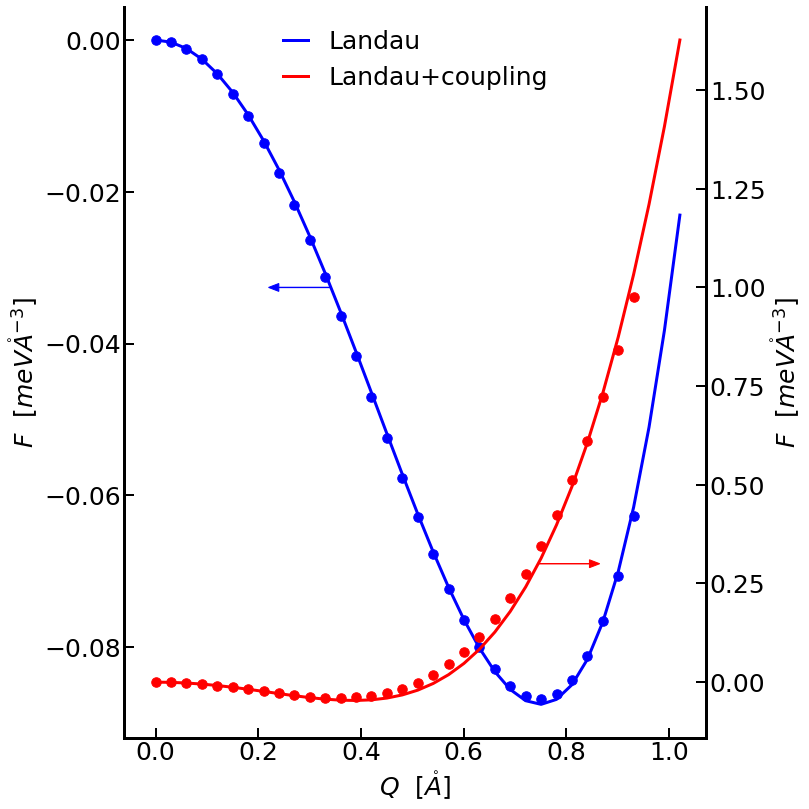

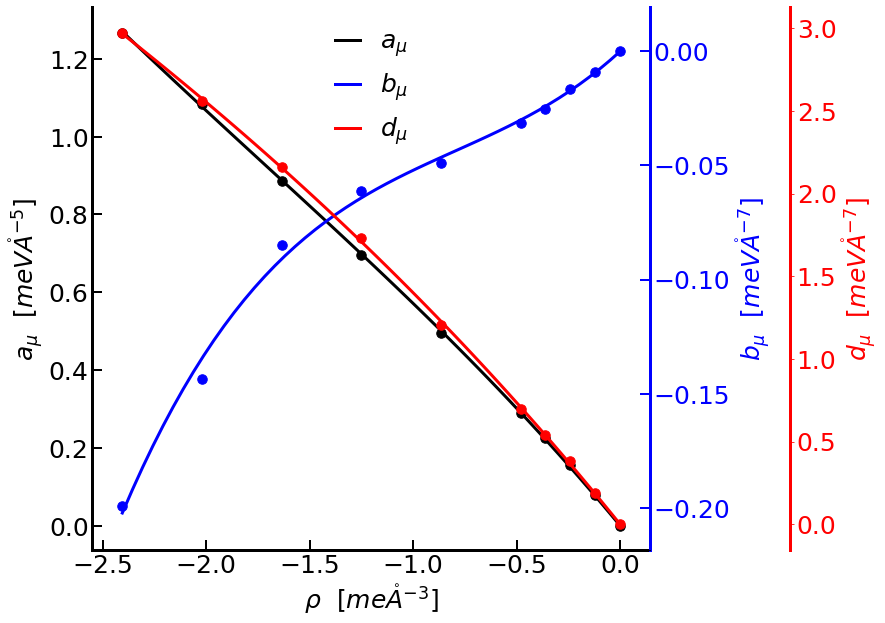

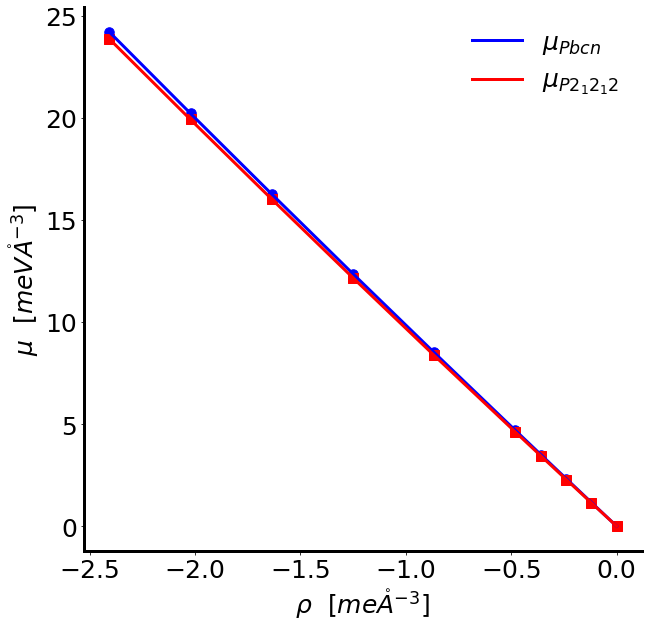

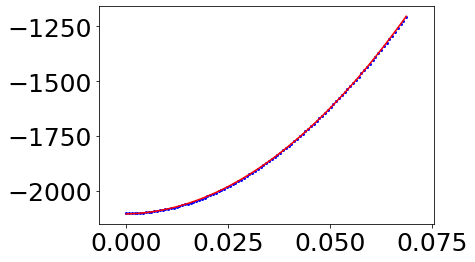

E_init: 226.369485 | charge_init: -120.000000
E_init: 430.843249 | charge_init: -120.000000
E_init: 659.585962 | charge_init: -120.000000
E: 60.863310 	|	 dE: -598.722652 	|	 total_charge: -119.999720
E: 11.098635 	|	 dE: -49.764676 	|	 total_charge: -119.999636
E: 44.926184 	|	 dE: -181.443301 	|	 total_charge: -119.999720
E: 6.462829 	|	 dE: -4.635805 	|	 total_charge: -119.999611
E: 5.819033 	|	 dE: -0.643796 	|	 total_charge: -119.999603
E: 28.584107 	|	 dE: -16.342078 	|	 total_charge: -119.999636
E: 5.497706 	|	 dE: -0.321327 	|	 total_charge: -119.999601
E: 5.243503 	|	 dE: -0.254202 	|	 total_charge: -119.999600
E: 27.069392 	|	 dE: -1.514715 	|	 total_charge: -119.999611
E: 5.100129 	|	 dE: -0.143374 	|	 total_charge: -119.999600
E: 5.030798 	|	 dE: -0.069332 	|	 total_charge: -119.999600
E: 26.923977 	|	 dE: -0.145414 	|	 total_charge: -119.999603
E: 4.997953 	|	 dE: -0.032844 	|	 total_charge: -119.999600
E: 22.095559 	|	 dE: -408.747690 	|	 total_charge: -119.999720
E: 4.98

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy as sc
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
import random as rnd
from scipy.optimize import minimize
import scipy.linalg
from scipy.optimize import Bounds
import multiprocessing

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#calculate Landau parameters and plot relevant curves
Landau = True
#calculate charge coupling parameter and plot relevant curves
charge = True
#calculate chemical potential
chempot = True
#calculate Ginzburg parameter
Ginzburg = True
#calculating Neel wall with fixed Q
Neel_fixQ = True
#calculating Neel wall with fixed Q and additional charge
Neel_fixQ_charge = True
#calculating Neel wall with variable Q
Neel_varQ = True
#calculating Neel wall with variable Q and additional charge
Neel_varQ_charge = True
#calculating Ising wall
Ising = True
#calculating Ising wall with additional charge
Ising_charge = True

prefix = "n200_c4E1"
data_write = True
data_read = False

#numerical minimization parameters
#number of points in grid
nsteps = 200
#length between grid points
dx = 1.5
#amplitude of initial phi step function
phi_init = np.pi/2
#amplitude of initial uniform q
q_init = 1
#value of initial uniform rho in meA^-3
rho_init = -4e-1
#scf convergence threshold
scf_conv = 1e-4
#tolerance for charge integral
charge_prec = abs(rho_init/1000)
#scf mixing factor
scf_mix = 0.7

parallel = True

#volume of unit cell in angstrom cubed for volume normalization
volume = 7.3236460686 * 7.7495899200 * 7.3236460686


#_________________________________PARAMETERS__________________________________________#

#Landau parameters for 6th order fit
#a_Q_6th
#b_Q_6th
#c_Q_6th

#Landau coupling parameters to 6th order
#d_2Q_6th
#e_2Q_6th

#amplitude Q value at 6th order Landau minimum
#Q0_6th 

#Landau parameters for 4th order fit
#!!!! not used as 6th order term in q is virtually 0 anyway !!!!
#a_Q_4th
#b_Q_4th

#charge coupling parameters for 6th order Landau fit 
#a_Q_e_6th_a
#a_Q_e_6th_b
#a_Q_e_6th_c
#b_Q_e_6th_a
#b_Q_e_6th_b
#b_Q_e_6th_c
#c_Q_e_6th_a
#c_Q_e_6th_b
#c_Q_e_6th_c
#d_Q_e_6th_a
#d_Q_e_6th_b
#d_Q_e_6th_c


#chemical potential 2nd order fit parameters for Pbcn phase
#a_chem_pot
#b_chem_pot

#chemical potential 2nd order fit parameters for P21212 phase
#a_chem_pot_2Q
#b_chem_pot_2Q

#Ginzburg parameter
#s

#________________________________________LANDAU______________________________________________#
#____________________________________________________________________________________________#
ry_to_mev = 13.605698066 * 1000
ry_to_thz = 3289.845
thz_to_mev = 0.00414E3
aut_to_a = 0.5291772083

if Landau and data_write:    
   
    #_________________________LOADING AND PREPARING ENERGY FILES__________________________________#
    E_Q_unstrained = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained.txt")
    E_2Q_unstrained = np.loadtxt("DATA/ENERGIES/energies_2Q_unstrained.txt")    
    
    #make a Q amplitude array
    Q = E_Q_unstrained[:,0]
    
    #convert Q to Angstrom amplitudes
    #Q[30] -> 0.9010 A
    Q /= Q[30] / 0.9010
    
    #subtract the bulk energy (amplitude = 0)
    E_bulk = E_Q_unstrained[0,1]
    E_Q_unstrained = E_Q_unstrained[:,1] - E_bulk
    E_2Q_unstrained = E_2Q_unstrained[:,1] - E_bulk   
    
    #energy unit conversion from Ry to meV and volume normalization
    E_Q_unstrained *= ry_to_mev / volume
    E_2Q_unstrained *= ry_to_mev / volume
    
    #_________________________COMPUTING LANDAU PARAMETERS__________________________________#
    
    #________________LANDAU Q UNSTRAINED_________________#
    #boundaries for Landau parameters    
    bnds = ([-np.inf, -np.inf, 0], np.inf)

    #fit the Landau energy to 6th order polynomial
    def Landau_Q_poly_6th(q, a, b, c):
        return a*(q**2) + b*(q**4) + c*(q**6)
    
    #poly of 4th order for Ising type wall
    #def Landau_Q_poly_4th(q, a, b):
    #    return a*(q**2) + b*(q**4)
    
    #find the Landau parameters by minimization
    popt_Landau_Q_6th, pcov_Landau_Q_6th = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained[0:32], bounds=bnds)
    #only take the first 30 points for the 4th order fit
    #popt_Landau_Q_4th, pcov_Landau_Q_4th = sc.optimize.curve_fit(Landau_Q_poly_4th, Q[0:32], E_Q_unstrained[0:32])
    
    #save the Landau parameters
    a_Q_6th = popt_Landau_Q_6th[0]
    b_Q_6th = popt_Landau_Q_6th[1]
    c_Q_6th = popt_Landau_Q_6th[2]
    
    #a_Q_4th = popt_Landau_Q_4th[0]
    #b_Q_4th = popt_Landau_Q_4th[1]
    
    #Q position of minimum
    Q0_6th = np.sqrt((np.sqrt((b_Q_6th**2)-3*a_Q_6th*c_Q_6th)-b_Q_6th) / c_Q_6th) / np.sqrt(3)
    
    #print the parameters
    print("Amplitude at minimum in A:")
    print(" Q0: %f" % (Q0_6th))
    
    print("Landau parameters in meV/A^x:")
    print(" a: %f" % (a_Q_6th))
    print(" b: %f" % (b_Q_6th))
    print(" c: %f" % (c_Q_6th))
    
    
    #________________LANDAU 2Q UNSTRAINED_________________#
    #bounds for Landau parameters    
    bnds = ([-np.inf, 0], np.inf)
    #fit the Landau coupling term using the 6th order Landau parameters
    def Landau_2Q_poly_6th(Q, d, e):
        q1, q2 = Q
        return a_Q_6th*(q1**2+q2**2) + \
               b_Q_6th*(q1**2 + q2**2)**2 + \
               c_Q_6th*(q1**2 + q2**2)**3 + \
               d * (q1**2)*(q2**2) + \
               e * ((q1**4)*(q2**2)+(q1**2)*(q2**4))
    
    popt_Landau_2Q, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained[0:32], bounds=bnds)
    
    #save the Landau coupling parameter
    d_2Q_6th = popt_Landau_2Q[0]
    e_2Q_6th = popt_Landau_2Q[1]
    
    #print the coupling parameter
    print("Landau coupling parameter in meV/A^x:")
    print(" d: %f" % (d_2Q_6th))
    print(" e: %f" % (e_2Q_6th))
    
    #___________________________________PLOTTING CURVES_______________________________________#
    #________________LANDAU Q UNSTRAINED_________________#
    #plot the Landau energy and its fit
    plt.figure(1, figsize=[10,10])
    plt.rcParams.update({'font.size': 25})

    #6th order fit
    plt.plot(Q[0:35], Landau_Q_poly_6th(Q[0:35], *popt_Landau_Q_6th), \
                                  color='blue', linewidth=3, label='Landau', zorder=1)
    #calculated energies
    plt.scatter(Q[0:32], E_Q_unstrained[0:32], color='blue', marker='o', s=90, zorder=2)
    #4th order fit
    #plt.scatter(Q[0:30], Landau_Q_poly_4th(Q[0:30], *popt_Landau_Q_4th), \
    #                              color='blue', marker='s', s=110, linewidths=2, facecolors='none', label='4th order fit')
    
   
    #________________LANDAU 2Q UNSTRAINED________________#
    ax = plt.gca()   
    ax2 = ax.twinx()  
    ax2.plot(Q[0:35], Landau_2Q_poly_6th((Q[0:35],Q[0:35]), *popt_Landau_2Q), color='red', linewidth=3, label='Landau+coupling')
    ax2.scatter(Q[0:32], E_2Q_unstrained[0:32], color='red', marker='o', s=90)
    
    #figure stuff
    ax2.arrow(0.34,1,-0.1,0, head_width = 0.02, head_length=0.02, facecolor='blue', edgecolor='blue')
    ax2.arrow(0.745,0.3,0.1,0, head_width = 0.02, head_length=0.02, facecolor='red', edgecolor='red')

    ax.relim()
    ax.autoscale()
    ax.tick_params(direction='in', length=10, width=2, grid_alpha=0.5)
    ax2.tick_params(direction='in', length=10, width=2, grid_alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax2.spines['right'].set_linewidth(3)
    ax.set_xlabel(r'$Q \ \ [\mathring{A}]$', fontsize=25)
    ax.set_ylabel(r'$F \ \ \left [meV\mathring{A}^{-3}\right]$', fontsize=25)
    ax2.set_ylabel(r'$F \ \ \left [meV\mathring{A}^{-3}\right]$', fontsize=25)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, frameon=False, handlelength=1, loc='upper center') 
    plt.tight_layout(-1.5)
    plt.savefig('Landau.eps', bbox_inches='tight')


#____________________________________________________________________________________________#
#____________________________________________________________________________________________#


#___________________________________CHARGE COUPLING__________________________________________#
#____________________________________________________________________________________________#
if charge and data_write:
    
    E_Q_unstrained_e005 = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained_e005.txt")
    E_Q_unstrained_e010 = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained_e010.txt")
    E_Q_unstrained_e015 = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained_e015.txt")
    E_Q_unstrained_e020 = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained_e020.txt")
    E_Q_unstrained_e036 = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained_e036.txt")
    E_Q_unstrained_e052 = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained_e052.txt")
    E_Q_unstrained_e068 = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained_e068.txt")
    E_Q_unstrained_e084 = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained_e084.txt")
    E_Q_unstrained_e1 = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained_e1.txt")
    
    E_2Q_unstrained_e005 = np.loadtxt("DATA/ENERGIES/energies_2Q_unstrained_e005.txt")
    E_2Q_unstrained_e010 = np.loadtxt("DATA/ENERGIES/energies_2Q_unstrained_e010.txt")
    E_2Q_unstrained_e015 = np.loadtxt("DATA/ENERGIES/energies_2Q_unstrained_e015.txt")    
    E_2Q_unstrained_e020 = np.loadtxt("DATA/ENERGIES/energies_2Q_unstrained_e020.txt")   
    E_2Q_unstrained_e036 = np.loadtxt("DATA/ENERGIES/energies_2Q_unstrained_e036.txt")   
    E_2Q_unstrained_e052 = np.loadtxt("DATA/ENERGIES/energies_2Q_unstrained_e052.txt")  
    E_2Q_unstrained_e068 = np.loadtxt("DATA/ENERGIES/energies_2Q_unstrained_e068.txt")  
    E_2Q_unstrained_e084 = np.loadtxt("DATA/ENERGIES/energies_2Q_unstrained_e084.txt")  
    E_2Q_unstrained_e1 = np.loadtxt("DATA/ENERGIES/energies_2Q_unstrained_e1.txt") 
        
    E_Q_unstrained_e005 = E_Q_unstrained_e005[:,1] - E_Q_unstrained_e005[0,1]
    E_Q_unstrained_e010 = E_Q_unstrained_e010[:,1] - E_Q_unstrained_e010[0,1]
    E_Q_unstrained_e015 = E_Q_unstrained_e015[:,1] - E_Q_unstrained_e015[0,1]
    E_Q_unstrained_e020 = E_Q_unstrained_e020[:,1] - E_Q_unstrained_e020[0,1]
    E_Q_unstrained_e036 = E_Q_unstrained_e036[:,1] - E_Q_unstrained_e036[0,1] 
    E_Q_unstrained_e052 = E_Q_unstrained_e052[:,1] - E_Q_unstrained_e052[0,1] 
    E_Q_unstrained_e068 = E_Q_unstrained_e068[:,1] - E_Q_unstrained_e068[0,1]   
    E_Q_unstrained_e084 = E_Q_unstrained_e084[:,1] - E_Q_unstrained_e084[0,1]   
    E_Q_unstrained_e1 = E_Q_unstrained_e1[:,1] - E_Q_unstrained_e1[0,1]  
    
    E_2Q_unstrained_e005 = E_2Q_unstrained_e005[:,1] - E_2Q_unstrained_e005[0,1]
    E_2Q_unstrained_e010 = E_2Q_unstrained_e010[:,1] - E_2Q_unstrained_e010[0,1]
    E_2Q_unstrained_e015 = E_2Q_unstrained_e015[:,1] - E_2Q_unstrained_e015[0,1]
    E_2Q_unstrained_e020 = E_2Q_unstrained_e020[:,1] - E_2Q_unstrained_e020[0,1]
    E_2Q_unstrained_e036 = E_2Q_unstrained_e036[:,1] - E_2Q_unstrained_e036[0,1]
    E_2Q_unstrained_e052 = E_2Q_unstrained_e052[:,1] - E_2Q_unstrained_e052[0,1]
    E_2Q_unstrained_e068 = E_2Q_unstrained_e068[:,1] - E_2Q_unstrained_e068[0,1]
    E_2Q_unstrained_e084 = E_2Q_unstrained_e084[:,1] - E_2Q_unstrained_e084[0,1]
    E_2Q_unstrained_e1 = E_2Q_unstrained_e1[:,1] - E_2Q_unstrained_e1[0,1]
    
    E_Q_unstrained_e005 *= ry_to_mev / volume
    E_Q_unstrained_e010 *= ry_to_mev / volume
    E_Q_unstrained_e015 *= ry_to_mev / volume
    E_Q_unstrained_e020 *= ry_to_mev / volume
    E_Q_unstrained_e036 *= ry_to_mev / volume
    E_Q_unstrained_e052 *= ry_to_mev / volume
    E_Q_unstrained_e068 *= ry_to_mev / volume
    E_Q_unstrained_e084 *= ry_to_mev / volume
    E_Q_unstrained_e1 *= ry_to_mev / volume
    
    E_2Q_unstrained_e005 *= ry_to_mev / volume
    E_2Q_unstrained_e010 *= ry_to_mev / volume
    E_2Q_unstrained_e015 *= ry_to_mev / volume
    E_2Q_unstrained_e020 *= ry_to_mev / volume
    E_2Q_unstrained_e036 *= ry_to_mev / volume
    E_2Q_unstrained_e052 *= ry_to_mev / volume
    E_2Q_unstrained_e068 *= ry_to_mev / volume
    E_2Q_unstrained_e084 *= ry_to_mev / volume
    E_2Q_unstrained_e1 *= ry_to_mev / volume

    #charge density in me per A^3
    charge = np.array([0, -0.05, -0.10, -0.15, -0.20, -0.36, -0.52, -0.68, -0.84, -1])
    rho = charge / volume * 1000
    
    a_Q_e_6th = np.empty(0)
    b_Q_e_6th = np.empty(0)
    
    d_2Q_e_6th = np.empty(0)
    e_2Q_e_6th = np.empty(0)
    
    #bounds for Landau parameters
    bnds = ([-np.inf, -np.inf, 0], np.inf)
    
    popt_Landau_Q_e, pcov_Landau_Q_e = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained[0:32], bounds=bnds)  
    a_Q_e_6th = np.append(a_Q_e_6th, popt_Landau_Q_e[0])
    b_Q_e_6th = np.append(b_Q_e_6th, popt_Landau_Q_e[1])
    popt_Landau_Q_e, pcov_Landau_Q_e = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained_e005[0:32], bounds=bnds)  
    a_Q_e_6th = np.append(a_Q_e_6th, popt_Landau_Q_e[0])
    b_Q_e_6th = np.append(b_Q_e_6th, popt_Landau_Q_e[1])
    popt_Landau_Q_e, pcov_Landau_Q_e = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained_e010[0:32], bounds=bnds)  
    a_Q_e_6th = np.append(a_Q_e_6th, popt_Landau_Q_e[0])
    b_Q_e_6th = np.append(b_Q_e_6th, popt_Landau_Q_e[1])
    popt_Landau_Q_e, pcov_Landau_Q_e = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained_e015[0:32], bounds=bnds)  
    a_Q_e_6th = np.append(a_Q_e_6th, popt_Landau_Q_e[0])
    b_Q_e_6th = np.append(b_Q_e_6th, popt_Landau_Q_e[1])
    popt_Landau_Q_e, pcov_Landau_Q_e = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained_e020[0:32], bounds=bnds)  
    a_Q_e_6th = np.append(a_Q_e_6th, popt_Landau_Q_e[0])
    b_Q_e_6th = np.append(b_Q_e_6th, popt_Landau_Q_e[1])
    popt_Landau_Q_e, pcov_Landau_Q_e = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained_e036[0:32], bounds=bnds)  
    a_Q_e_6th = np.append(a_Q_e_6th, popt_Landau_Q_e[0])
    b_Q_e_6th = np.append(b_Q_e_6th, popt_Landau_Q_e[1])
    popt_Landau_Q_e, pcov_Landau_Q_e = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained_e052[0:32], bounds=bnds)  
    a_Q_e_6th = np.append(a_Q_e_6th, popt_Landau_Q_e[0])
    b_Q_e_6th = np.append(b_Q_e_6th, popt_Landau_Q_e[1])
    popt_Landau_Q_e, pcov_Landau_Q_e = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained_e068[0:32], bounds=bnds)  
    a_Q_e_6th = np.append(a_Q_e_6th, popt_Landau_Q_e[0])
    b_Q_e_6th = np.append(b_Q_e_6th, popt_Landau_Q_e[1])
    popt_Landau_Q_e, pcov_Landau_Q_e = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained_e084[0:32], bounds=bnds)  
    a_Q_e_6th = np.append(a_Q_e_6th, popt_Landau_Q_e[0])
    b_Q_e_6th = np.append(b_Q_e_6th, popt_Landau_Q_e[1])
    popt_Landau_Q_e, pcov_Landau_Q_e = sc.optimize.curve_fit(Landau_Q_poly_6th, Q[0:32], E_Q_unstrained_e1[0:32], bounds=bnds)  
    a_Q_e_6th = np.append(a_Q_e_6th, popt_Landau_Q_e[0])
    b_Q_e_6th = np.append(b_Q_e_6th, popt_Landau_Q_e[1])
 
    #bounds for Landau parameters    
    bnds = ([-np.inf, 0], np.inf)
    
    popt_Landau_2Q_e, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained[0:32], bounds=bnds)
    d_2Q_e_6th = np.append(d_2Q_e_6th, popt_Landau_2Q_e[0])
    e_2Q_e_6th = np.append(e_2Q_e_6th, popt_Landau_2Q_e[1])
    popt_Landau_2Q_e, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained_e005[0:32], bounds=bnds)
    d_2Q_e_6th = np.append(d_2Q_e_6th, popt_Landau_2Q_e[0])
    e_2Q_e_6th = np.append(e_2Q_e_6th, popt_Landau_2Q_e[1])
    popt_Landau_2Q_e, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained_e010[0:32], bounds=bnds)
    d_2Q_e_6th = np.append(d_2Q_e_6th, popt_Landau_2Q_e[0])
    e_2Q_e_6th = np.append(e_2Q_e_6th, popt_Landau_2Q_e[1])
    popt_Landau_2Q_e, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained_e015[0:32], bounds=bnds)
    d_2Q_e_6th = np.append(d_2Q_e_6th, popt_Landau_2Q_e[0])
    e_2Q_e_6th = np.append(e_2Q_e_6th, popt_Landau_2Q_e[1])
    popt_Landau_2Q_e, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained_e020[0:32], bounds=bnds)
    d_2Q_e_6th = np.append(d_2Q_e_6th, popt_Landau_2Q_e[0])
    e_2Q_e_6th = np.append(e_2Q_e_6th, popt_Landau_2Q_e[1])
    popt_Landau_2Q_e, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained_e036[0:32], bounds=bnds)
    d_2Q_e_6th = np.append(d_2Q_e_6th, popt_Landau_2Q_e[0])
    e_2Q_e_6th = np.append(e_2Q_e_6th, popt_Landau_2Q_e[1])
    popt_Landau_2Q_e, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained_e052[0:32], bounds=bnds)
    d_2Q_e_6th = np.append(d_2Q_e_6th, popt_Landau_2Q_e[0])
    e_2Q_e_6th = np.append(e_2Q_e_6th, popt_Landau_2Q_e[1])
    popt_Landau_2Q_e, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained_e068[0:32], bounds=bnds)
    d_2Q_e_6th = np.append(d_2Q_e_6th, popt_Landau_2Q_e[0])
    e_2Q_e_6th = np.append(e_2Q_e_6th, popt_Landau_2Q_e[1])
    popt_Landau_2Q_e, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained_e084[0:32], bounds=bnds)
    d_2Q_e_6th = np.append(d_2Q_e_6th, popt_Landau_2Q_e[0])
    e_2Q_e_6th = np.append(e_2Q_e_6th, popt_Landau_2Q_e[1])
    popt_Landau_2Q_e, pcov_Landau_2Q = sc.optimize.curve_fit(Landau_2Q_poly_6th, (Q[0:32],Q[0:32]), E_2Q_unstrained_e1[0:32], bounds=bnds)
    d_2Q_e_6th = np.append(d_2Q_e_6th, popt_Landau_2Q_e[0])
    e_2Q_e_6th = np.append(e_2Q_e_6th, popt_Landau_2Q_e[1])
    
    def e_coupling(rho, a, b, c, d):
        return a*rho + b*rho**2 + c*rho**3
    
    popt_e_coupling_6th_a, pcov_e_coupling_6th_a = sc.optimize.curve_fit(e_coupling, rho, a_Q_e_6th - a_Q_6th)
    a_Q_e_6th_a = popt_e_coupling_6th_a[0]
    a_Q_e_6th_b = popt_e_coupling_6th_a[1]   
    a_Q_e_6th_c = popt_e_coupling_6th_a[2] 
    
    popt_e_coupling_6th_b, pcov_e_coupling_6th_b = sc.optimize.curve_fit(e_coupling, rho, b_Q_e_6th - b_Q_6th)
    b_Q_e_6th_a = popt_e_coupling_6th_b[0]
    b_Q_e_6th_b = popt_e_coupling_6th_b[1]    
    b_Q_e_6th_c = popt_e_coupling_6th_b[2]

    popt_e_coupling_6th_d, pcov_e_coupling_6th_d = sc.optimize.curve_fit(e_coupling, rho, d_2Q_e_6th - d_2Q_6th)
    d_2Q_e_6th_a = popt_e_coupling_6th_d[0]
    d_2Q_e_6th_b = popt_e_coupling_6th_d[1]   
    d_2Q_e_6th_c = popt_e_coupling_6th_d[2] 
    
    popt_e_coupling_6th_e, pcov_e_coupling_6th_e = sc.optimize.curve_fit(e_coupling, rho, e_2Q_e_6th - e_2Q_6th)
    e_2Q_e_6th_a = popt_e_coupling_6th_e[0]
    e_2Q_e_6th_b = popt_e_coupling_6th_e[1]    
    e_2Q_e_6th_c = popt_e_coupling_6th_e[2]
    
    print("charge coupling parameter Pbcn in meV/A^x:")
    print(" a_a: %f" % (a_Q_e_6th_a))
    print(" a_b: %f" % (a_Q_e_6th_b))
    print(" a_c: %f" % (a_Q_e_6th_c))
    print(" b_a: %f" % (b_Q_e_6th_a))
    print(" b_b: %f" % (b_Q_e_6th_b))
    print(" b_c: %f" % (b_Q_e_6th_c))
    
    print("charge coupling parameter P21212 in meV/A^x:")
    print(" d_a: %f" % (d_2Q_e_6th_a))
    print(" d_b: %f" % (d_2Q_e_6th_b))
    print(" d_c: %f" % (d_2Q_e_6th_c))
    print(" e_a: %f" % (e_2Q_e_6th_a))
    print(" e_b: %f" % (e_2Q_e_6th_b))
    print(" e_c: %f" % (e_2Q_e_6th_c))
       
    plt.figure(4, figsize = (10,10))
    ax = plt.gca()
    ax.scatter(rho, a_Q_e_6th - a_Q_6th, color='black', marker='o', s=90)
    ax.plot(np.linspace(rho[len(rho)-1],0), e_coupling(np.linspace(rho[len(rho)-1],0), *popt_e_coupling_6th_a), color='black', linewidth=3, label='$a_\mu$')
     
    ax2 = ax.twinx()
    ax2.scatter(rho, b_Q_e_6th - b_Q_6th, color='blue', marker='o', s=90)
    ax2.plot(np.linspace(rho[len(rho)-1],0), e_coupling(np.linspace(rho[len(rho)-1],0), *popt_e_coupling_6th_b), color='blue', linewidth=3, label='$b_\mu$')

    ax3 = ax.twinx()    
    ax3.scatter(rho, d_2Q_e_6th - d_2Q_6th, color='red', marker='o', s=90)
    ax3.plot(np.linspace(rho[len(rho)-1],0), e_coupling(np.linspace(rho[len(rho)-1],0), *popt_e_coupling_6th_d), color='red', linewidth=3, label='$d_\mu$')

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, frameon=False, handlelength=1, loc='upper center')
    
    ax.set_xlabel(r'$\rho \ \ [me\mathring{A}^{-3}]$', fontsize=25)
    ax.set_ylabel(r'$a_\mu \ \ [meV\mathring{A}^{-5}]$', fontsize=25)
    ax2.set_ylabel(r'$b_\mu \ \ [meV\mathring{A}^{-7}]$', fontsize=25)
    ax3.set_ylabel(r'$d_\mu \ \ [meV\mathring{A}^{-7}]$', fontsize=25)   
    ax.tick_params(direction='in', length=10, width=2, grid_alpha=0.5)
    ax2.tick_params(direction='in', length=10, width=2, grid_alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax2.spines['right'].set_linewidth(3)
    ax3.spines['right'].set_linewidth(3)
    ax3.spines["right"].set_position(("axes", 1.25))
    ax2.spines["right"].set_color("blue")
    ax3.spines["right"].set_color("red")
    ax2.yaxis.label.set_color("blue")
    ax3.yaxis.label.set_color("red")
    ax2.tick_params(colors="blue")
    ax3.tick_params(colors="red")
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    ax.relim()
    ax.autoscale()
    plt.savefig('Landau_charge.eps', bbox_inches='tight')
   
    
#____________________________________________________________________________________________#
#____________________________________________________________________________________________#

#___________________________________CHEMICAL POTENTIAL_______________________________________#
#____________________________________________________________________________________________#

if chempot and data_write:
    E_Q26_chem_pot = np.loadtxt("DATA/ENERGIES/energies_chem_pot_Q26.txt")
    E_2Q13_chem_pot = np.loadtxt("DATA/ENERGIES/energies_chem_pot_2Q13.txt")

    #charge density in me per A^3
    rho = -E_Q26_chem_pot[:,0] / volume * 1000
    
    E_Q26_chem_pot = E_Q26_chem_pot[:,1] * ry_to_mev / volume
    E_2Q13_chem_pot = E_2Q13_chem_pot[:,1] * ry_to_mev / volume
    
    E_Q26_chem_pot -= E_Q26_chem_pot[0]
    E_2Q13_chem_pot -= E_2Q13_chem_pot[0]
    
    def chem_pot_poly(rho, a, b):
        return a*rho + b*rho**2 
    
    popt_chem_pot_Q26, pcov_Landau_chem_pot_Q26 = sc.optimize.curve_fit(chem_pot_poly, rho, E_Q26_chem_pot)  
    popt_chem_pot_2Q13, pcov_Landau_chem_pot_2Q13 = sc.optimize.curve_fit(chem_pot_poly, rho, E_2Q13_chem_pot)
    a_chem_pot = popt_chem_pot_Q26[0]
    b_chem_pot = popt_chem_pot_Q26[1]
    
    a_chem_pot_2Q = popt_chem_pot_2Q13[0]
    b_chem_pot_2Q = popt_chem_pot_2Q13[1]
    
    print("chemical potential parameters in meV/me^-xA^-3:")
    print(" mu: %f" % (a_chem_pot))
    print(" mu': %f" % (b_chem_pot))

    plt.figure(5, figsize=[10,10])
    plt.scatter(rho, E_Q26_chem_pot, color='blue', marker='o', s=90)
    plt.plot(rho, chem_pot_poly(rho, *popt_chem_pot_Q26), color='blue', linewidth=3, label='$\mu_{Pbcn}$')
    
    plt.scatter(rho, E_2Q13_chem_pot, color='red', marker='s', s=90)
    plt.plot(rho, chem_pot_poly(rho, *popt_chem_pot_2Q13), color='red', linewidth=3, label='$\mu_{P2_12_12}$')
    
    ax = plt.gca()
    ax.set_xlabel(r'$\rho \ \ [me\mathring{A}^{-3}]$', fontsize=25)
    ax.set_ylabel(r'$\mu \ \ [meV\mathring{A}^{-3}]$', fontsize=25)  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.relim()
    ax.autoscale()
    ax.legend(frameon=False)
    plt.savefig('chemical_potential.eps', bbox_inches='tight')
#____________________________________________________________________________________________#
#____________________________________________________________________________________________#


#_________________________________________GINZBURG___________________________________________#
#____________________________________________________________________________________________#
#Note: explicitly calculating the dynmat or force constant matrix at specific q's and then calculating
#s by using finite differences yields very unsatisfactory results. Instead the real-space ifc was calculated on
#a q grid and the respective dynmats were then fourier interpolated with the realspace ifc.

if Ginzburg and data_write:
    #load the dynmats (actually force constant matrices) centered at M and in the [1/2,1/2,0] direction
    #only along positive direction as it is the same in the negative direction due to symmetry
    dynmats_M_filename = 'DATA/DYNMAT/M.dyn'
    dynmat_GM_filename = 'DATA/DYNMAT/GM.dyn'
    
    nat = 16
    ndyn = 101
    dq = 0.04
    modenum = 3 #at M the modenumber to Pbcn is 2 however the bands cross after the first q-increment
    
    #dynamical matrix format:
    # -index1: floor(index1/3) -> atom index 1
    #         index%3 -> coordinate index of corresponding atom
    # -index2: floor(index2/3) -> atom index 2
    #         index%3 -> coordinate index of corresponding atom    
    
    #____________READ GM DYNMAT_____________#
    dynmat_GM = np.empty([nat*3, nat*3], dtype = complex)
    fil_dynmat_GM = open(dynmat_GM_filename, 'r')
    #skip the first 5 lines
    for i in range(0, 5):
        fil_dynmat_GM.readline()
    
    for i in range(0, nat):
        for j in range(0, nat):
            fil_dynmat_GM.readline()
            for k in range(0, 3):
                line = fil_dynmat_GM.readline().split()
                for l in range(0, 3):
                    number = np.complex(float(line[l*2]), float(line[l*2+1]))
                    dynmat_GM[i*3+k, j*3+l] = number 
                    
    #____________IMPOSE DYNMAT HERMITICITY_____________#
    for i in range(0, nat * 3):
         for j in range(0, nat * 3):
                dynmat_GM[i,j] = 0.5 * (dynmat_GM[i,j] + dynmat_GM[j,i].conjugate())
                dynmat_GM[j,i] = dynmat_GM[i,j].conjugate() 
                    
    #____________READ M DYNMATS_____________#
    w2fh_vec = np.empty(ndyn)
    fil_dynmats_M = open(dynmats_M_filename, 'r')
    for idyn in range(0, ndyn):       
        dynmat = np.empty([nat*3, nat*3], dtype = complex)
        
        #skip the first 5 lines
        for i in range(0, 5):
            fil_dynmats_M.readline()
        
        for i in range(0, nat):
            for j in range(0, nat):
                fil_dynmats_M.readline()
                for k in range(0, 3):
                    line = fil_dynmats_M.readline().split()
                    for l in range(0, 3):
                        number = np.complex(float(line[l*2]), float(line[l*2+1]))
                        dynmat[i*3+k, j*3+l] = number
    
        #____________IMPOSE DYNMAT HERMITICITY_____________#
        for i in range(0, nat * 3):
             for j in range(0, nat * 3):
                    dynmat[i,j] = 0.5 * (dynmat[i,j] + dynmat[j,i].conjugate())
                    dynmat[j,i] = dynmat[i,j].conjugate()  
                    
        #____________IMPOSE ACOUSTIC SUM RULE_______________#
        dynmat_asr = np.empty([nat*3,nat*3], dtype = complex)
        for i in range(0, nat * 3):
            for j in range(0, nat * 3):
                if int(np.floor(i/3)) == int(np.floor(j/3)):
                    asrsum = 0
                    ic = j % 3  #coordinate index
                    for k in range(0, nat):
                        asrsum += float(dynmat_GM[i, k*3 + ic])               
                    dynmat_asr[i,j] = dynmat[i,j] - complex(asrsum,0)
                else:
                    dynmat_asr[i,j] = dynmat[i,j]  
    
        dynmat = dynmat_asr     

        #____________DIAGONALIZE WITH ZHEEV_____________#
        #get force constant matrix eigenvalues and eigenvectors
        w2fh, evfh, inf = scipy.linalg.lapack.zheev(dynmat)
        #convert to meV
        w2fh *= ry_to_mev
        #convert to Angstrom
        w2fh /= aut_to_a**2
        w2fh_vec[idyn] = w2fh[modenum]
        
        #convert eigenvectors from row to column vectors
        evfh = evfh.transpose()    
        
    #____________CALCULATE S_____________#
    #by fitting to quadratic function in q
    def Ginzburg_poly(q, s, a, b):
        return a + s * (q + b)**2
    
    lat_tetr = 5.177972730
    lat_tetr_inv = 1/lat_tetr * 2*np.pi
    
    x = np.linspace(0,
                    np.sqrt(2*(dq*lat_tetr_inv)**2),
                    ndyn)
    
    p0 = [1000, w2fh_vec[0], 0]
    popt_Ginzburg, pcov_Ginzburg = sc.optimize.curve_fit(Ginzburg_poly, x , w2fh_vec, p0)
    
    s = popt_Ginzburg[0] / 2
    s /= volume
    
    print("Ginzburg parameter in meV/A^3:")
    print(" s: %f" % (s))
        
    plt.figure(51)
    plt.scatter(x, w2fh_vec, color='blue', s=4)
    plt.plot(x, Ginzburg_poly(x, *popt_Ginzburg), color='red')

plt.show()

#____________________________________________________________________________________________#
#____________________________________________________________________________________________#

#______________________________________DOMAIN_WALLS__________________________________________#
#____________________________________________________________________________________________#

#_______________________NEEL FIXED Q0/NO CHARGE____________________________#
if Neel_fixQ and data_write:
    
    def compute_Neel_fixQ(parallel=False):
        #____________NUMERICAL______________#
        phi = np.zeros(nsteps)
        phi[int(phi.size/2):phi.size] = phi_init
        
        x = np.linspace(0, nsteps*dx, nsteps)
        x -= x[x.size - 1] / 2 
        
        def Landau_Ginzburg(phi): 
            d_phi = np.gradient(phi, dx)
            E_tot = 0
            for i in range(0, phi.size):
                Landau = a_Q_6th * Q0_6th**2 + b_Q_6th * Q0_6th**4 + c_Q_6th * Q0_6th**6
                Landau_coupling = (d_2Q_6th * Q0_6th**4 + e_2Q_6th * Q0_6th**6) * np.cos(phi[i])**2 * np.sin(phi[i])**2
                Ginzburg = s * Q0_6th**2 * d_phi[i]**2
                E_tot += (Landau + Landau_coupling + Ginzburg) * dx
            return E_tot
        
        phi_min = minimize(Landau_Ginzburg, phi, method='BFGS')
        phi_min = phi_min.x    
        
        #____________ANALYTICAL______________#
        epsilon =  np.sqrt((d_2Q_6th * Q0_6th**2 + e_2Q_6th * Q0_6th**4) / s)
        analytical = np.array(np.arctan(np.exp(x * epsilon)))
        
        if not parallel:
            #_______________PLOT_________________#    
            plt.figure(6, figsize=[10,10])
            
            plt.plot(x, phi_min, color='blue', label='numerical', linewidth=5)
            plt.plot(x, analytical, color='red', label='analytical', linewidth=5, linestyle='-.')
          
            plt.xlabel('$x [\mathring{A}]$', fontsize=30)
            plt.ylabel('$ \phi [rad]$', fontsize=30)
            plt.legend()
            plt.tight_layout()
        
        
        #___________WRITE TO FILE____________#
        file_num = open('DATA/DOMAIN_WALLS/' + prefix + '.Neel_fixQ_num', 'w')
        file_ana = open('DATA/DOMAIN_WALLS/' + prefix + '.Neel_fixQ_ana', 'w')
        for i in range(0, len(x)):
            file_num.write("%f\t%f\n" %(x[i], phi_min[i]))
            file_ana.write("%f\t%f\n" %(x[i], analytical[i]))
        file_num.close()
        file_ana.close()  
    
    if parallel:
        proc_Neel_fixQ = multiprocessing.Process(target=compute_Neel_fixQ, args=(parallel,))
        proc_Neel_fixQ.start()
    else:
        compute_Neel_fixQ()

        
#_______________________________________________________________________#

#______________________NEEL FIXED Q0/WITH CHARGE________________________#
if Neel_fixQ_charge and data_write:
    
    def compute_Neel_fixQ_charge(parallel=False):
        #____________NUMERICAL______________#
        #initializing phi(x) and rho(x)
        #phi as a step function from 0 to phi_init 
        phi = np.zeros(nsteps)
        phi[int(phi.size/2):phi.size] = phi_init
        #rho as uniform charge density rho_init
        rho = np.zeros(nsteps) + rho_init
    
        #x grid of size nsteps*dx centered at 0
        x = np.linspace(0, nsteps*dx, nsteps)
        x -= x[x.size - 1] / 2 
        
        #simple riemann integral
        def integral(x, f):
            riemann1 = 0
            riemann2 = 0
            for i in range(0, x.size-1):
                riemann1 += (x[i+1]-x[i])*f[i]
                riemann2 += (x[i+1]-x[i])*f[i+1]
            return (riemann1 + riemann2)/2
        
        #calculating initial total charge
        total_charge = integral(x, rho)
        
        #integral constraint for rho -> total charge must not change
        def integral_constraint(rho):
            return charge_prec-abs(integral(x, rho) - total_charge)
        
        cons = [{'type':'ineq', 'fun': integral_constraint}] 
    
        #boundaries for rho    
        bnds = []
        for i in range(0, rho.size):
            bnds.append((None, 0))
        
        
        #Landau Ginzburg energy where rho is kept fixed
        def Landau_Ginzburg_const_rho(phi):
            d_phi = np.diff(phi)/dx
            d_phi = np.append(d_phi, d_phi[0])  
            E_tot = 0
            for i in range(0, phi.size):
                a = a_Q_6th + a_Q_e_6th_a * rho[i] + a_Q_e_6th_b * rho[i]**2 + a_Q_e_6th_c * rho[i]**3 
                b = b_Q_6th + b_Q_e_6th_a * rho[i] + b_Q_e_6th_b * rho[i]**2 + b_Q_e_6th_c * rho[i]**3
                d = d_2Q_6th + d_2Q_e_6th_a * rho[i] + d_2Q_e_6th_b * rho[i]**2 + d_2Q_e_6th_c * rho[i]**3
                Landau = a * Q0_6th**2 + b * Q0_6th**4 + c_Q_6th * Q0_6th**6
                Landau_coupling = (d * Q0_6th**4 + e_2Q_6th * Q0_6th**6) * np.cos(phi[i])**2 * np.sin(phi[i])**2
                Ginzburg = s * Q0_6th**2 * d_phi[i]**2
                chem_pot = b_chem_pot * rho[i]**2
                E_tot += (Landau + Landau_coupling + Ginzburg + chem_pot) * dx
            return E_tot
        
        #Landau Ginzburg energy where phi is kept fixed
        def Landau_Ginzburg_const_phi(rho):
            d_phi = np.diff(phi)/dx
            d_phi = np.append(d_phi, d_phi[0])  
            E_tot = 0
            for i in range(0, phi.size):
                a = a_Q_6th + a_Q_e_6th_a * rho[i] + a_Q_e_6th_b * rho[i]**2 + a_Q_e_6th_c * rho[i]**3 
                b = b_Q_6th + b_Q_e_6th_a * rho[i] + b_Q_e_6th_b * rho[i]**2 + b_Q_e_6th_c * rho[i]**3
                d = d_2Q_6th + d_2Q_e_6th_a * rho[i] + d_2Q_e_6th_b * rho[i]**2 + d_2Q_e_6th_c * rho[i]**3
                Landau = a * Q0_6th**2 + b * Q0_6th**4 + c_Q_6th * Q0_6th**6
                Landau_coupling = (d * Q0_6th**4 + e_2Q_6th * Q0_6th**6) * np.cos(phi[i])**2 * np.sin(phi[i])**2
                Ginzburg = s * Q0_6th**2 * d_phi[i]**2
                chem_pot = b_chem_pot * rho[i]**2
                E_tot += (Landau + Landau_coupling + Ginzburg + chem_pot) * dx
            return E_tot
        
        #scf cycle
        E_new = Landau_Ginzburg_const_phi(rho)
        dE = abs(scf_conv) + 1
        print("E_init: %f | charge_init: %f" % (E_new, total_charge))
        while abs(dE) > scf_conv:
            E_old = E_new
            
            phi_old = phi
            phi_min = minimize(Landau_Ginzburg_const_rho, phi, method = 'BFGS')
            phi_min = phi_min.x
            phi = phi_min * scf_mix + (1-scf_mix)*phi_old
            
            rho_old = rho
            rho_min = minimize(Landau_Ginzburg_const_phi, rho, constraints = cons, bounds = bnds, method = 'SLSQP')
            rho_min = rho_min.x
            rho = rho_min * scf_mix + (1-scf_mix)*rho_old
            E_new = Landau_Ginzburg_const_phi(rho)
            dE = E_new - E_old
            print("E: %f \t|\t dE: %f \t|\t total_charge: %f" % (E_new, dE, integral(x,rho)))
       
            if not parallel:
                #_______________PLOT_________________#
                plt.figure(7, figsize=[10,10])
                ax = plt.gca()
                ax2 = ax.twinx()
                
                ax.plot(x, phi_min, color='blue', label=r'$\phi$',linewidth=5)
                ax2.plot(x, rho_min, color='red', label=r'$\rho$', linewidth=5)
                
                ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
                ax.set_ylabel(r'$\phi [rad]$', fontsize=30)
                ax2.set_ylabel(r'$\rho$', fontsize=30)

            
        
        #___________WRITE TO FILE____________#    
        file = open('DATA/DOMAIN_WALLS/' + prefix + '.Neel_fixQ_charge', 'w')
        for i in range(0, len(x)):
            file.write("%f\t%f\t%f\n" %(x[i], phi_min[i], rho_min[i]))
        file.close()

    if parallel:
        proc_Neel_fixQ_charge = multiprocessing.Process(target=compute_Neel_fixQ_charge, args=(parallel,))
        proc_Neel_fixQ_charge.start()
    else:
        compute_Neel_fixQ_charge()

#_______________________________________________________________________#


#______________________NEEL VARIABLE Q0/NO CHARGE______________________#
if Neel_varQ and data_write:
    
    def compute_Neel_varQ(parallel=False):
        #____________NUMERICAL______________#
        #initializing phi(x),q(x)
        #phi as a step function from 0 to phi_init 
        phi = np.zeros(nsteps)
        phi[int(phi.size/2):phi.size] = phi_init
        #q as a uniform amplitude q_init
        q = np.zeros(nsteps) + q_init
        
        phi_q = np.append(phi, q)
        
        #x grid of size nsteps*dx centered at 0
        x = np.linspace(0, nsteps*dx, nsteps)
        x -= x[x.size - 1] / 2 
        
        #Landau Ginzburg energy
        def Landau_Ginzburg(phi_q):
            phi = phi_q[0:int(phi_q.size/2)]
            q = phi_q[int(phi_q.size/2):phi_q.size]
            d_phi = np.diff(phi)/dx
            d_phi = np.append(d_phi, d_phi[0])
            d_q = np.diff(q)/dx
            d_q = np.append(d_q, d_q[0])
            E_tot = 0
            for i in range(0, phi.size):
                Landau = a_Q_6th * q[i]**2 + b_Q_6th * q[i]**4 + c_Q_6th * q[i]**6
                Landau_coupling = (d_2Q_6th * q[i]**4 + e_2Q_6th * q[i]**6) * np.cos(phi[i])**2 * np.sin(phi[i])**2
                Ginzburg = s*(q[i]**2 * d_phi[i]**2 + d_q[i]**2)
                E_tot += (Landau + Landau_coupling + Ginzburg) * dx
            return E_tot
        
        phi_q_min = minimize(Landau_Ginzburg, phi_q, method = 'BFGS')
        phi_q_min = phi_q_min.x
        phi_min = phi_q_min[0:int(phi_q_min.size/2)]
        q_min = phi_q_min[int(phi_q_min.size/2):phi_q.size]
        
        if not parallel:
            #_______________PLOT_________________#
            plt.figure(8, figsize=[10,10])
            ax = plt.gca()
            ax2 = ax.twinx()
                   
            ax.plot(x, phi_min, color='blue', label=r'$\phi$',linewidth=5)
            ax2.plot(x, q_min, color='red', label=r'$q', linewidth=5)
                  
            ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
            ax.set_ylabel(r'$\phi [rad]$', fontsize=30)
            ax2.set_ylabel(r'$q [\mathring{A}]$', fontsize=30)
    
         
        #___________WRITE TO FILE____________#
        file = open('DATA/DOMAIN_WALLS/' + prefix + '.Neel_varQ', 'w')
        for i in range(0, len(x)):
            file.write("%f\t%f\t%f\n" %(x[i], phi_min[i], q_min[i]))        
        file.close() 
        
    if parallel:
        proc_Neel_varQ = multiprocessing.Process(target=compute_Neel_varQ, args=(parallel,))
        proc_Neel_varQ.start()
    else:
        compute_Neel_varQ()


#____________________NEEL VARIABLE Q0/WITH CHARGE______________________#
if Neel_varQ_charge and data_write:
    
    def compute_Neel_varQ_charge(parallel=False):
        #____________NUMERICAL______________#
        #initializing phi(x),q(x) and rho(x)
        #phi as a step function from 0 to phi_init 
        phi = np.zeros(nsteps)
        phi[int(phi.size/2):phi.size] = phi_init
        #q as a uniform amplitude q_init
        q = np.zeros(nsteps) + q_init
        #rho as uniform charge density rho_init
        rho = np.zeros(nsteps) + rho_init
        
        phi_q = np.append(phi, q)
    
        #x grid of size nsteps*dx centered at 0
        x = np.linspace(0, nsteps*dx, nsteps)
        x -= x[x.size - 1] / 2 
        
        #simple riemann integral
        def integral(x, f):
            riemann1 = 0
            riemann2 = 0
            for i in range(0, x.size-1):
                riemann1 += (x[i+1]-x[i])*f[i]
                riemann2 += (x[i+1]-x[i])*f[i+1]
            return (riemann1 + riemann2)/2
        
        #calculating initial total charge
        total_charge = integral(x, rho)
        
        #integral constraint for rho -> total charge must not change
        def integral_constraint(rho):
            return charge_prec-abs(integral(x, rho) - total_charge)
        
        cons = [{'type':'ineq', 'fun': integral_constraint}] 
        
        #boundaries for rho    
        bnds = []
        for i in range(0, rho.size):
            bnds.append((None, 0))
        
        #Landau Ginzburg energy where rho is kept fixed
        def Landau_Ginzburg_const_rho(phi_q):
            phi = phi_q[0:int(phi_q.size/2)]
            q = phi_q[int(phi_q.size/2):phi_q.size]
            d_phi = np.diff(phi)/dx
            d_phi = np.append(d_phi, d_phi[0])
            d_q = np.diff(q)/dx
            d_q = np.append(d_q, d_q[0])
            E_tot = 0
            for i in range(0, phi.size):
                a = a_Q_6th + a_Q_e_6th_a * rho[i] + a_Q_e_6th_b * rho[i]**2 + a_Q_e_6th_c * rho[i]**3 
                b = b_Q_6th + b_Q_e_6th_a * rho[i] + b_Q_e_6th_b * rho[i]**2 + b_Q_e_6th_c * rho[i]**3
                d = d_2Q_6th + d_2Q_e_6th_a * rho[i] + d_2Q_e_6th_b * rho[i]**2 + d_2Q_e_6th_c * rho[i]**3
                Landau = a*q[i]**2 + b*q[i]**4 + c_Q_6th*q[i]**6
                Landau_coupling = (d * q[i]**4 + e_2Q_6th * q[i]**6) * np.cos(phi[i])**2 * np.sin(phi[i])**2
                Ginzburg = s*((q[i]**2) * (d_phi[i]**2) + (d_q[i]**2))
                chem_pot = b_chem_pot * rho[i]**2
                E_tot += (Landau + Landau_coupling + Ginzburg + chem_pot) * dx
            return E_tot
        
        
        #Landau Ginzburg energy where phi and q are kept fixed
        def Landau_Ginzburg_const_phi_q(rho):
            d_phi = np.diff(phi)/dx
            d_phi = np.append(d_phi, d_phi[0])
            d_q = np.diff(q)/dx
            d_q = np.append(d_q, d_q[0])
            E_tot = 0
            for i in range(0, phi.size):
                a = a_Q_6th + a_Q_e_6th_a * rho[i] + a_Q_e_6th_b * rho[i]**2 + a_Q_e_6th_c * rho[i]**3 
                b = b_Q_6th + b_Q_e_6th_a * rho[i] + b_Q_e_6th_b * rho[i]**2 + b_Q_e_6th_c * rho[i]**3
                d = d_2Q_6th + d_2Q_e_6th_a * rho[i] + d_2Q_e_6th_b * rho[i]**2 + d_2Q_e_6th_c * rho[i]**3
                Landau = a*q[i]**2 + b*q[i]**4 + c_Q_6th*q[i]**6
                Landau_coupling = (d * q[i]**4 + e_2Q_6th * q[i]**6) * np.cos(phi[i])**2 * np.sin(phi[i])**2
                Ginzburg = s*((q[i]**2) * (d_phi[i]**2) + (d_q[i]**2))
                chem_pot = b_chem_pot * rho[i]**2
                E_tot += (Landau + Landau_coupling + Ginzburg + chem_pot) * dx
            return E_tot
        
        #scf cycle
        E_new = Landau_Ginzburg_const_phi_q(rho)
        dE = abs(scf_conv) + 1
        print("E_init: %f | charge_init: %f" % (E_new, total_charge))
        while abs(dE) > scf_conv:
            E_old = E_new
            Ginzburg_glob=0
            
            phi_old = phi
            q_old = q
            phi_q_min = minimize(Landau_Ginzburg_const_rho, phi_q, method = 'BFGS')
            phi_q_min = phi_q_min.x
            phi_min = phi_q_min[0:int(phi_q_min.size/2)]
            q_min = phi_q_min[int(phi_q_min.size/2):phi_q.size]
            phi = phi_min * scf_mix + (1-scf_mix)*phi_old
            q = q_min * scf_mix + (1-scf_mix)*q_old
    
            rho_old = rho
            rho_min = minimize(Landau_Ginzburg_const_phi_q, rho, constraints = cons, bounds = bnds, method = 'SLSQP')
            rho_min = rho_min.x
            rho = rho_min * scf_mix + (1-scf_mix)*rho_old
    
            E_new = Landau_Ginzburg_const_phi_q(rho)
            dE = E_new - E_old
            print("E: %f \t|\t dE: %f \t|\t total_charge: %f" % (E_new, dE, integral(x,rho)))
    
            if not parallel:
                #_______________PLOT_________________#    
                
                plt.figure(9, figsize=[10,10])
                ax = plt.gca()
                ax2 = ax.twinx()
                
                ax.plot(x, phi_min, color='blue', label=r'$\phi(x)$', linewidth=5)
                ax2.plot(x, q_min, color='red', label=r'$q(x)$', linewidth=5)
                
                ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
                ax.set_ylabel(r'$ \phi [rad]$', fontsize=30)
                ax2.set_ylabel(r'$q [\mathring{A}]$', fontsize=30)
                lines, labels = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax2.legend(lines + lines2, labels + labels2, frameon=False, bbox_to_anchor=(0.51,0.2), handlelength=1) 

                
                
        #___________WRITE TO FILE____________#
        file = open('DATA/DOMAIN_WALLS/' + prefix + '.Neel_varQ_charge', 'w')
        for i in range(0, len(x)):
            file.write("%f\t%f\t%f\t%f\n" %(x[i], phi_min[i], q_min[i], rho_min[i]))        
        file.close() 

    if parallel:
        proc_Neel_varQ_charge = multiprocessing.Process(target=compute_Neel_varQ_charge, args=(parallel,))
        proc_Neel_varQ_charge.start()
    else:
        compute_Neel_varQ_charge()

        

#_______________________________________________________________________#

#__________________________ISING/NO CHARGE______________________________#

if Ising and data_write:
    
    def compute_Ising(parallel=False):
        #____________NUMERICAL______________#
        Q = np.zeros(nsteps) - q_init
        Q[int(Q.size/2) : Q.size] = q_init
        
        #x grid of size nsteps*dx centered at 0
        x = np.linspace(0, nsteps*dx, nsteps)
        x -= x[x.size - 1] / 2 
        
        def Landau_Ginzburg(Q):
            d_Q = np.diff(Q)/dx
            d_Q = np.append(d_Q, d_Q[0])
            E_tot = 0
            for i in range(0, Q.size - 1):
                Landau = a_Q_6th*(Q[i]**2) + b_Q_6th*(Q[i]**4)
                Ginzburg = s * (d_Q[i]**2)
                E_tot += (Landau + Ginzburg) * dx
            return E_tot
        
        Q_min = minimize(Landau_Ginzburg, Q, method='BFGS')
        Q_min = Q_min.x
            
        #____________ANALYTICAL______________#
        epsilon = np.sqrt(-s / a_Q_6th )
        Q0 = np.sqrt(-a_Q_6th / (2* b_Q_6th))    
        analytical = np.array(Q0*np.tanh(x/(np.sqrt(2)*epsilon)))
    
        if not parallel:
            #_______________PLOT_________________#    
            plt.figure(10, figsize=[10,10])
            plt.plot(x, Q_min, color='blue', linewidth=5, label='numerical')
            plt.plot(x, analytical, color='red', linestyle='-.', linewidth=5, label='analytical')
        
            plt.xlabel(r'$x [\mathring{A}]$', fontsize=30)
            plt.ylabel(r'$q [\mathring{A}]$', fontsize=30)
        
            plt.tight_layout()
            plt.savefig('Landau_Ginzburg.eps', bbox_inches='tight')   
        
        #___________WRITE TO FILE____________#
        file_num = open('DATA/DOMAIN_WALLS/' + prefix + '.Ising_num', 'w')
        file_ana = open('DATA/DOMAIN_WALLS/' + prefix + '.Ising_ana', 'w')
        for i in range(0, len(x)):
            file_num.write("%f\t%f\n" %(x[i], Q_min[i]))
            file_ana.write("%f\t%f\n" %(x[i], analytical[i]))
        file_num.close()
        file_ana.close() 
        
    if parallel:
        proc_Ising = multiprocessing.Process(target=compute_Ising, args=(parallel,))
        proc_Ising.start()
    else:
        compute_Ising()
    
    
#_________________________________________________________________________#

#__________________________ISING/WITH CHARGE______________________________#
if Ising_charge and data_write:
    
    def compute_Ising_charge(parallel=False):
        #____________NUMERICAL______________#    
        Q = np.zeros(nsteps) - q_init
        Q[int(Q.size/2) : Q.size] = q_init
        
        rho = np.zeros(nsteps) + rho_init
        
        #x grid of size nsteps*dx centered at 0
        x = np.linspace(0, nsteps*dx, nsteps)
        x -= x[x.size - 1] / 2 
          
        #simple riemann integral
        def integral(x, f):
            riemann1 = 0
            riemann2 = 0
            for i in range(0, x.size-1):
                riemann1 += (x[i+1]-x[i])*f[i]
                riemann2 += (x[i+1]-x[i])*f[i+1]
            return (riemann1 + riemann2)/2
        
        #calculating initial total charge
        total_charge = integral(x, rho)
        
        #integral constraint for rho -> total charge must not change
        def integral_constraint(rho):
            return charge_prec-abs(integral(x, rho) - total_charge)
        
        cons = [{'type':'ineq', 'fun': integral_constraint}] 
        
        #boundaries for rho    
        bnds = []
        for i in range(0, rho.size):
            bnds.append((None, 0))
        
        def Landau_Ginzburg_const_rho(Q):
            d_Q = np.diff(Q)/dx
            d_Q = np.append(d_Q, d_Q[0])
            E_tot = 0
            for i in range(0, Q.size):
                a = a_Q_6th + a_Q_e_6th_a * rho[i] + a_Q_e_6th_b * rho[i]**2 + a_Q_e_6th_c * rho[i]**3 
                b = b_Q_6th + b_Q_e_6th_a * rho[i] + b_Q_e_6th_b * rho[i]**2 + b_Q_e_6th_c * rho[i]**3
                Landau = a*(Q[i]**2) + b*(Q[i]**4)
                Ginzburg = s * (d_Q[i]**2)
                chem_pot = b_chem_pot * rho[i]**2
                E_tot += (Landau + Ginzburg + chem_pot) * dx
            return E_tot
        
        def Landau_Ginzburg_const_Q(rho):
            d_Q = np.diff(Q)/dx
            d_Q = np.append(d_Q, d_Q[0])
            E_tot = 0
            for i in range(0, Q.size):
                a = a_Q_6th + a_Q_e_6th_a * rho[i] + a_Q_e_6th_b * rho[i]**2 + a_Q_e_6th_c * rho[i]**3 
                b = b_Q_6th + b_Q_e_6th_a * rho[i] + b_Q_e_6th_b * rho[i]**2 + b_Q_e_6th_c * rho[i]**3
                Landau = a*(Q[i]**2) + b*(Q[i]**4)
                Ginzburg = s * (d_Q[i]**2)
                chem_pot = b_chem_pot * rho[i]**2
                E_tot += (Landau + Ginzburg + chem_pot) * dx
            return E_tot
    
        #scf cycle
        E_new = Landau_Ginzburg_const_Q(rho)
        dE = abs(scf_conv) + 1
        print("E_init: %f | charge_init: %f" % (E_new, total_charge))
        while abs(dE) > scf_conv:
            E_old = E_new
            Ginzburg_glob=0
            
            Q_old = Q
            Q_min = minimize(Landau_Ginzburg_const_rho, Q, method = 'BFGS')
            Q_min = Q_min.x
            Q = Q_min * scf_mix + (1-scf_mix)*Q_old
                        
            rho_old = rho
            rho_min = minimize(Landau_Ginzburg_const_Q, rho, constraints = cons, bounds = bnds, method = 'SLSQP')
            rho_min = rho_min.x
            rho = rho_min * scf_mix + (1-scf_mix)*rho_old
            E_new = Landau_Ginzburg_const_Q(rho)
            dE = E_new - E_old
            print("E: %f \t|\t dE: %f \t|\t total_charge: %f" % (E_new, dE, integral(x,rho)))
    
        if not parallel:   
            #_______________PLOT_________________#
            plt.figure(11, figsize=[10,10])
            ax = plt.gca()
            ax2 = ax.twinx()
            
            ax.plot(x, Q_min, color='blue', label=r'$\Q$',linewidth=5)
            ax2.plot(x, rho_min, color='red', label=r'$\rho$', linewidth=5)
            
            ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
            ax.set_ylabel(r'$Q [\mathring{A}]$', fontsize=30)
            ax2.set_ylabel(r'$\rho$', fontsize=30)
        
        #___________WRITE TO FILE____________#
        file = open('DATA/DOMAIN_WALLS/' + prefix + '.Ising_charge', 'w')
        for i in range(0, len(x)):
            file.write("%f\t%f\t%f\n" %(x[i], Q_min[i], rho_min[i]))        
        file.close() 
        
    if parallel:
        proc_Ising_charge = multiprocessing.Process(target=compute_Ising_charge, args=(parallel,))
        proc_Ising_charge.start()
    else:
        compute_Ising_charge()
        
if data_write and parallel:
    if Neel_fixQ:
        proc_Neel_fixQ.join()
    if Neel_fixQ_charge:
        proc_Neel_fixQ_charge.join()
    if Neel_varQ:
        proc_Neel_varQ.join()
    if Neel_varQ_charge:
        proc_Neel_varQ_charge.join()
    if Ising:
        proc_Ising.join()
    if Ising_charge:
        proc_Ising_charge.join()
#_________________________________________________________________________________#
#___________________________PLOTTING FROM FILE____________________________________#
        
if Neel_fixQ and data_read:
    x_phi_num = np.loadtxt('DATA/DOMAIN_WALLS/' + prefix + '.Neel_fixQ_num')
    x = x_phi_num[:,0]
    phi_num = x_phi_num[:,1]
    
    x_phi_ana = np.loadtxt('DATA/DOMAIN_WALLS/' + prefix + '.Neel_fixQ_ana')
    phi_ana = x_phi_ana[:,1]
    
    plt.figure(12, figsize=[10,10])
    
    plt.plot(x, phi_num, color='blue', label='numerical', linewidth=5)
    plt.plot(x, phi_ana, color='red', label='analytical', linewidth=5, linestyle='-.')
  
    plt.xlabel(r'$x [\mathring{A}]$', fontsize=30)
    plt.ylabel(r'$r\phi [rad]$', fontsize=30)
    plt.legend()
    plt.tight_layout()
    
if Neel_fixQ_charge and data_read:
    x_phi_rho = np.loadtxt('DATA/DOMAIN_WALLS/' + prefix + '.Neel_fixQ_charge')
    x = x_phi_rho[:,0]
    phi = x_phi_rho[:,1]
    rho = x_phi_rho[:,2]
    
    plt.figure(13, figsize=[10,10])
    ax = plt.gca()
    ax2 = ax.twinx()
    
    ax.plot(x, phi, color='blue', label=r'$\phi$',linewidth=5)
    ax2.plot(x, rho, color='red', label=r'$\rho$', linewidth=5)
    
    ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
    ax.set_ylabel(r'$\phi [rad]$', fontsize=30)
    ax2.set_ylabel(r'$\rho$', fontsize=30)
    
if Neel_varQ and data_read:
    x_phi_q = np.loadtxt('DATA/DOMAIN_WALLS/' + prefix + '.Neel_varQ')
    x = x_phi_q[:,0]
    phi = x_phi_q[:,1]
    q = x_phi_q[:,2]    
  
    plt.figure(14, figsize=[10,10])
    ax = plt.gca()
    ax2 = ax.twinx()
    
    ax.plot(x, phi, color='blue', label=r'$\phi$',linewidth=5)
    ax2.plot(x, q, color='red', label='$q$', linewidth=5)
    
    ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
    ax.set_ylabel(r'$\phi [rad]$', fontsize=30)
    ax2.set_ylabel(r'$q [\mathring{A}]$', fontsize=30)
    
if Neel_varQ_charge and data_read:
    x_phi_q_rho = np.loadtxt('DATA/DOMAIN_WALLS/' + prefix + '.Neel_varQ_charge')
    x = x_phi_q_rho[:,0]
    phi = x_phi_q_rho[:,1]
    q = x_phi_q_rho[:,2]   
    rho = x_phi_q_rho[:,3]
  
    plt.figure(15, figsize=[10,10])
    ax = plt.gca()
    ax2 = ax.twinx()
    
    ax.plot(x, phi, color='blue', label=r'$\phi$',linewidth=5)
    ax2.plot(x, q, color='red', label=r'$q$', linewidth=5)
    
    ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
    ax.set_ylabel(r'$\phi [rad]$', fontsize=30)
    ax2.set_ylabel(r'$q [\mathring{A}]$', fontsize=30)
    
    plt.figure(16, figsize=[10,10])
    ax = plt.gca()
    ax2 = ax.twinx()
    
    ax.plot(x, phi, color='blue', label=r'$\phi$',linewidth=5)
    ax2.plot(x, rho, color='red', label=r'$\rho$', linewidth=5)
    
    ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
    ax.set_ylabel(r'$\phi [rad]$', fontsize=30)
    ax2.set_ylabel(r'$\rho$', fontsize=30)
    

if Ising and data_read:
    x_Q_num = np.loadtxt('DATA/DOMAIN_WALLS/' + prefix + '.Ising_num')
    x = x_Q_num[:,0]
    Q_num = x_Q_num[:,1]
    
    x_Q_ana = np.loadtxt('DATA/DOMAIN_WALLS/' + prefix + '.Ising_ana')
    Q_ana = x_Q_ana[:,1]
    
    plt.figure(17, figsize=[10,10])
    
    plt.plot(x, Q_num, color='blue', label='numerical', linewidth=5)
    plt.plot(x, Q_ana, color='red', label='analytical', linewidth=5, linestyle='-.')
  
    plt.xlabel('r$x [\mathring{A}]$', fontsize=30)
    plt.ylabel('r$Q [\mathring{A}]$', fontsize=30)
    plt.legend()
    plt.tight_layout()
    
if Ising_charge and data_read:    
    x_Q_rho = np.loadtxt('DATA/DOMAIN_WALLS/' + prefix + '.Ising_charge')
    x = x_Q_rho[:,0]
    Q = x_Q_rho[:,1]
    rho = x_Q_rho[:,2]
    
    plt.figure(18, figsize=[10,10])
    ax = plt.gca()
    ax2 = ax.twinx()
    
    ax.plot(x, Q, color='blue', label=r'$\phi$',linewidth=5)
    ax2.plot(x, rho, color='red', label=r'$\rho$', linewidth=5)
    
    ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
    ax.set_ylabel(r'$Q [\mathring{A}]$', fontsize=30)
    ax2.set_ylabel(r'$\rho$', fontsize=30)

    
plt.show()
print("done")

In [53]:
#procedure to calculate the Ginzburg parameter s by finite differences
#with 3 dynmats explicitly calculated at specific q points

#___________READING FORCE CONSTANT MATRICES_____________#
#dynmat at q_M1
dynmat_0_temp = np.loadtxt("DATA/DYNMAT/dynmat_0")
#dynmat at q_M1 - dq
dynmat_mq_temp = np.loadtxt("DATA/DYNMAT/dynmat_mq")
#dynmat at q_M1 - 1/2*dq
dynmat_mq2_temp = np.loadtxt("DATA/DYNMAT/dynmat_mq2")
#dynmat at Gamma for acoustic sum rule
dynmat_GM_temp = np.loadtxt("DATA/DYNMAT/dynmat_GM")

nat = dynmat_0_temp.shape[0]
nat = int(np.sqrt(nat/3))
#dynamical matrix:
# -index 1: floor(index/3) -> atom index 1
#         index%3 -> coordinate index of corresponding atom
# -index 2: floor(index/3) -> atom index 2
#         index%3 -> coordinate index of corresponding atom

dynmat_GM = np.empty([nat*3, nat*3], dtype = complex)
dynmat_0 = np.empty([nat*3,nat*3], dtype = complex)
dynmat_mq = np.empty([nat*3, nat*3], dtype = complex)
dynmat_mq2 = np.empty([nat*3, nat*3], dtype = complex)

temp_index1 = 0
for i in range(0, nat):          #block index atom 1
    for j in range(0, 3):                 #coordinate index
        temp_index2 = 0
        for k in range(0, nat):  #block index atom 2 in atom 1
            shift = i*nat*3 + j + k*3
            for l in range(0,3):
                dynmat_0[temp_index1, temp_index2] = np.complex(dynmat_0_temp[shift, l*2], dynmat_0_temp[shift, l*2 + 1])
                dynmat_mq[temp_index1, temp_index2] = np.complex(dynmat_mq_temp[shift, l*2], dynmat_mq_temp[shift, l*2 + 1])
                dynmat_mq2[temp_index1, temp_index2] = np.complex(dynmat_mq2_temp[shift, l*2], dynmat_mq2_temp[shift, l*2 + 1])
                dynmat_GM[temp_index1, temp_index2] = np.complex(dynmat_GM_temp[shift, l*2], dynmat_GM_temp[shift, l*2 + 1])
                temp_index2 += 1
        temp_index1 += 1
        
        

    
#____________IMPOSE DYNMAT HERMITICITY_____________#
for i in range(0, nat * 3):
     for j in range(0, nat * 3):
            dynmat_GM[i,j] = 0.5 * (dynmat_GM[i,j] + dynmat_GM[j,i].conjugate())
            dynmat_GM[j,i] = dynmat_GM[i,j].conjugate()
            dynmat_0[i,j] = 0.5 * (dynmat_0[i,j] + dynmat_0[j,i].conjugate())
            dynmat_0[j,i] = dynmat_0[i,j].conjugate()
            dynmat_mq[i,j] = 0.5 * (dynmat_mq[i,j] + dynmat_mq[j,i].conjugate())
            dynmat_mq[j,i] = dynmat_mq[i,j].conjugate()
            dynmat_mq2[i,j] = 0.5 * (dynmat_mq2[i,j] + dynmat_mq2[j,i].conjugate())
            dynmat_mq2[j,i] = dynmat_mq2[i,j].conjugate()
            dynmat_GM[i,j] = 0.5 * (dynmat_GM[i,j] + dynmat_GM[j,i].conjugate())
            dynmat_GM[j,i] = dynmat_GM[i,j].conjugate()
                    
                          

#_________DIAGONALIZE DYNMATS WITH ZHEEV____________#
w2h_0, evh_0, inf = scipy.linalg.lapack.zheev(dynmat_0)
w2h_mq, evh_mq, inf = scipy.linalg.lapack.zheev(dynmat_mq)
w2h_mq2, evh_mq2, inf = scipy.linalg.lapack.zheev(dynmat_mq2)

#convert eigenvectors from row to column vectors
evh_0 = evh_0.transpose()
evh_mq = evh_mq.transpose()
evh_mq2 = evh_mq2.transpose()
    
#_________CALCULATE FREQUENCIES______________#   
   
w2h_0 *= ry_to_thz**2
w2h_mq *= ry_to_thz**2
w2h_mq2 *= ry_to_thz**2 

wh_0 = np.sqrt(abs(w2h_0))
wh_mq = np.sqrt(abs(w2h_mq))
wh_mq2 = np.sqrt(abs(w2h_mq2))

for i in range(0, wh_0.size):
    if w2h_0[i] < 0:
        wh_0[i] = -wh_0[i]
    if w2h_mq[i] < 0:
        wh_mq[i] = -wh_mq[i]
    if w2h_mq2[i] < 0:
        wh_mq2[i] = -wh_mq2[i]
    
#____________CALCULATE FREQUENCY FROM READ EIGENVECTORS_________________#

#read eigenvectors
evr_0_temp = np.loadtxt("DATA/DYNMAT/eigenvector_0")
evr_mq_temp = np.loadtxt("DATA/DYNMAT/eigenvector_mq")
evr_mq2_temp = np.loadtxt("DATA/DYNMAT/eigenvector_mq2")

#eigenvectors
# -index: floor(index/3) -> atom index
#         index%3 -> coordinate index of corresponding atom
evr_0 = np.empty(shape=(nat * 3, nat * 3), dtype = complex)
evr_mq = np.empty(shape=(nat * 3, nat * 3), dtype = complex)
evr_mq2 = np.empty(shape=(nat * 3, nat * 3), dtype = complex)

for i in range(0, nat * 3):
    temp_index = 0
    for j in range(0, nat):
        for k in range(0, 3):
            evr_0[i, temp_index] = np.complex(evr_0_temp[i*nat+j, k*2], evr_0_temp[i*nat+j, k*2 + 1])
            evr_mq[i, temp_index] = np.complex(evr_mq_temp[i*nat+j, k*2], evr_mq_temp[i*nat+j, k*2 + 1])
            evr_mq2[i, temp_index] = np.complex(evr_mq2_temp[i*nat+j, k*2], evr_mq2_temp[i*nat+j, k*2 + 1])
            temp_index += 1
            
w2r_0 = np.empty(nat * 3)
w2r_mq = np.empty(nat * 3)
w2r_mq2 = np.empty(nat * 3)

wr_0 = np.empty(nat * 3)
wr_mq = np.empty(nat * 3)
wr_mq2 = np.empty(nat * 3)

for i in range(0, nat * 3):
    #remultiply the read eigenvectors by the sqrt of the mass as the eigenvectors are actually the phonon
    #eigendisplacements
    for j in range(0, nat * 3):
        if j >= 12*3:
            mass = 167559.909473597
        else:
            mass = 14582.5610075711
        evr_0[i,j] *= np.sqrt(mass)
        evr_mq[i,j] *= np.sqrt(mass)
        evr_mq2[i,j] *= np.sqrt(mass) 
    
    #normalize their lengths
    evr_0[i] /= np.sqrt(evr_0[i].conjugate().dot(evr_0[i]))
    evr_mq[i] /= np.sqrt(evr_mq[i].conjugate().dot(evr_mq[i]))
    evr_mq2[i] /= np.sqrt(evr_mq2[i].conjugate().dot(evr_mq2[i]))

    #calculate squared frequencies
    w2r_0[i] = evr_0[i].conjugate().dot(dynmat_0.dot(evr_0[i]))
    w2r_mq[i] = evr_mq[i].conjugate().dot(dynmat_mq.dot(evr_mq[i]))
    w2r_mq2[i] = evr_mq2[i].conjugate().dot(dynmat_mq2.dot(evr_mq2[i]))
    
    #convert squared frequencies from Ry to THz
    w2r_0[i] *= ry_to_thz**2
    w2r_mq[i] *= ry_to_thz**2
    w2r_mq2[i] *= ry_to_thz**2
            
    #get the frequencies from the squared frequencies
    wr_0[i] = np.sqrt(abs(w2r_0[i]))
    wr_mq[i] = np.sqrt(abs(w2r_mq[i]))
    wr_mq2[i] = np.sqrt(abs(w2r_mq2[i]))
    if w2r_0[i] < 0:
        wr_0[i] = -wr_0[i]
    if w2r_mq[i] < 0:
        wr_mq[i] = -wr_mq[i]
    if w2r_mq2[i] < 0:
        wr_mq2[i] = -wr_mq2[i]

#compare frequencies from read and calculated eigenvectors to make sure everything is correct
#if asr is employed the frequencies obtained from the read eigenvectors will obviously be wrong and not match
print("Mode frequencies in THz:")
print(" q0: %f (%f)" % (wh_0[modenumber], wr_0[modenumber]))
print(" 0.5q-: %f (%f)" % (wh_mq2[modenumber], wr_mq2[modenumber]))
print(" q-: %f (%f)" % (wh_mq[modenumber], wr_mq[modenumber]))

#__________COMPUTE THE GINZBURG PARAMETER______________#
#convert the dynamical matrices back to the force constant matrices by multiplying with the masses
for i in range(0, nat * 3):
    if i >= 12*3:
        mass1 = 167559.909473597
    else:
        mass1 = 14582.5610075711
    for j in range(0, nat*3):
        if j >= 12*3:
            mass2 = 167559.909473597
        else:
            mass2 = 14582.5610075711            
        dynmat_0[i,j] *= np.sqrt(mass1 * mass2)
        dynmat_mq[i,j] *= np.sqrt(mass1 * mass2)
        dynmat_mq2[i,j] *= np.sqrt(mass1 * mass2)
             
#get force constant matrix eigenvalues and eigenvectors
w2fh_0, evfh_0, inf = scipy.linalg.lapack.zheev(dynmat_0)
w2fh_mq, evfh_mq, inf = scipy.linalg.lapack.zheev(dynmat_mq)
w2fh_mq2, evfh_mq2, inf = scipy.linalg.lapack.zheev(dynmat_mq2)

#convert eigenvectors from row to column vectors
evfh_0 = evfh_0.transpose()
evfh_mq = evfh_mq.transpose()
evfh_mq2 = evfh_mq2.transpose()
        
#finite difference increment
dq = np.sqrt(2*(0.005*2*np.pi/13.9274461)**2)
    
#compute s from the eigenvalues of the force constant matrix
sfh = -2*w2fh_mq[modenumber] + 32*w2fh_mq2[modenumber] - 30*w2fh_0[modenumber]
sfh /= 12*(dq**2) 
sfh *= ry_to_mev / volume  

s = 10
                
print("Ginzburg parameter in meV:")
print(" s: %f" % (sfh))

Mode frequencies in THz:


NameError: name 'modenumber' is not defined

[-0.31202515 -0.2358087  -0.16202874 -0.09050187 -0.02104465  0.18944685
  0.38663367  0.57652617  0.76513472  0.9584697 ]


NameError: name 'rho_min' is not defined